In [72]:
import os
import tensorflow as tf
import itertools
import numpy as np
from multiprocessing import Pool, Value, Array
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
import keras.backend as K
K.set_image_dim_ordering('th')

from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [2]:
class Ataxx:
    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7))   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board
            
    def get_feature_map(self, turn):
        friendly_map = (self.data == turn).astype(float)
        opponent_map = (self.data == -turn).astype(float)
        return np.concatenate((friendly_map.reshape((1, 7, 7)), opponent_map.reshape((1, 7, 7))), axis=0)
    
    def get_mask(self, turn, init=0.001):   # zero(init) out all illegal move positions
        moves = self.get_moves(turn)
        moves = list(zip(*self.get_moves(turn)))
        if len(moves) == 0:
            return np.zeros((2, 7, 7))
        else:
            start_pos = tuple(zip(*moves[0]))
            end_pos = tuple(zip(*moves[1]))
            start_mask = np.ones((7, 7)) * init
            start_mask[start_pos] = 1
            end_mask = np.ones((7, 7)) * init
            end_mask[end_pos] = 1
            return np.concatenate((start_mask.reshape((1, 7, 7)), end_mask.reshape((1, 7, 7))), axis=0)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif self.data[pos] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    pos_tmp = (pos[0]+dr, pos[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == turn:  # convert any piece of the opponent to 'turn'
                            return True
            return False
        
    def get_moves(self, turn):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1")
        else:
            next_moves = []
            for r in range(7):
                for c in range(7):
                    has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                    if self.is_valid(turn, (r, c)): # duplicate move
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                if abs(dr) <= 1 and abs(dc) <=1 and has_duplicate_move: 
                                    continue        # no need to record same move again
                                else:
                                    pos_tmp = (r+dr, c+dc)
                                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                                        if self.data[pos_tmp] == turn:
                                            next_moves.append((pos_tmp, (r, c)))
            return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        store_data = self.data.copy()
        best_score = -1000000
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                self.data[pos0] = 0
                self.data[pos1] = turn
            else:                                    # duplicate move
                self.data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[pos_tmp] = turn
                            
    def simu_move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("You are not moving your piece")
        else:
            tmp_data = self.data.copy()
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                tmp_data[pos0] = 0
                tmp_data[pos1] = turn
            else:                                    # duplicate move
                tmp_data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if tmp_data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            tmp_data[pos_tmp] = turn
            return tmp_data
    
    def evaluate(self, turn, this_turn, max_score=100, min_score=0.1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        else:
            turn_no = 0
            op_no = 0
            for r in range(7):
                for c in range(7):
                    if self.data[r, c] == turn:
                        turn_no += 1
                    elif self.data[r, c] == -turn:
                        op_no += 1
            if turn_no + op_no == 49:
                if turn_no > op_no:
                    return max_score
                else:
                    return -max_score
            else:
                if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
                    if turn_no > op_no:
                        return max_score
                    else:
                        return -max_score
                else:
                    value = turn_no - op_no
            return value * min_score

In [3]:
class Relay():
    def __init__(self, max_size):
        self.relay = []
        self.max_size = max_size

    def reset(self):
        self.relay = []
        
    def add_sample(self, new_sample):
        if len(self.relay) >= self.max_size:
            self.relay.pop(0)
        self.relay.append(new_sample)
    
    def get_batch(self, batch_size):
        if len(self.relay) < batch_size:
            print('not enough sample')
            raise ValueError('relay not large enough')
        else:
            batch = sample(self.relay, batch_size)
            # generate random array to decide the orientation of the data augmentation
            is_flip = np.random.random(batch_size) < 0.5
            rot_times = (np.random.random(batch_size) * 4).astype(int)
            
            cur_state = np.array([self.augmentation(item[0], is_flip[i], rot_times[i]) 
                                  for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_mask = np.array([self.augmentation(item[1], is_flip[i], rot_times[i])
                                 for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_action = np.array([self.augmentation(item[2], is_flip[i], rot_times[i])
                                   for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            try:
                cur_reward = np.array([item[3] for item in batch]).reshape(-1)
                new_state = np.array([self.augmentation(item[4], is_flip[i], rot_times[i])
                                      for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
                new_mask = np.array([self.augmentation(item[5], is_flip[i], rot_times[i])
                                      for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            except:
                cur_reward = None
                new_state = None
                new_mask = None
            return cur_state, cur_mask, cur_action, cur_reward, new_state, new_mask
    
    def augmentation(self, data, is_flip, rot_time): # data must have three dimentions and depth first
        if data is None:
            return None
        else:
            if is_flip:
                data = np.fliplr(data)
            data = np.rot90(data, k=rot_time, axes=(1, 2))
            return data
    
    def size(self):
        return len(self.relay)

# BatchNormalization helps in hard-to-tune lr situations

In [322]:
def neg_log_loss(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, 1, 98))
    y_pred = K.reshape(y_pred, (-1, 1, 98))
    y_log = K.log(y_pred)
    y_concate = K.concatenate([y_true, y_log], axis=1)
    y_prod = K.prod(y_concate, axis=1)
    return -K.sum(y_prod)


class CriticNetwork(object):
    def __init__(self, TAU=0.001, LEARNING_RATE=0):
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        #Now create the model
        #with tf.device("/cpu:0"):
        self.model = self.create_critic_network() 
        self.target_model = self.create_critic_network() 
        self.target_model.set_weights(self.model.get_weights())
        
    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        board_input = Input(shape=(2, 7, 7))
        x = Conv2D(32, (1, 1), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        board_feature = MaxPooling2D((2, 2))(x)

        action_input = Input(shape=(2, 7, 7))
        x = Conv2D(32, (1, 1), activation='relu', padding='same')(action_input)
        x = BatchNormalization(axis=1)(x)
        action_feature = MaxPooling2D((2, 2))(x)
        
        overall_feature = concatenate([board_input, action_input], axis=1)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(overall_feature)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
        x = Dense(1)(x)
        # construct model
        model = Model(inputs=[board_input, action_input], outputs=[x])
        print("actor")
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
        return model
    
class ActorNetwork(object):
    def __init__(self, TAU=0.001, LEARNING_RATE=0, pretrain_epoch=2, is_train=True, \
                 file_name='target_actor_model.h5'):
        if is_train:
            self.TAU = TAU
            self.LEARNING_RATE = LEARNING_RATE
            
            #Now create the model
            self.model= self.create_actor_network()   
            self.target_model= self.create_actor_network() 
            self.target_model.set_weights(self.model.get_weights())
            if not pretrain_epoch == 0:
                try:
                    self.model.load_weights('pretrained_actor_model.h5')
                    print("succesfully loaded the pretrained model")
                except:
                    print("start to pre train with greedy")
                    self.learn_rules(batch_size=512, epochs=pretrain_epoch)
                    self.model.save_weights('pretrained_actor_model.h5')
        else:
            try:
                self.target_model = load_model(file_name)
                print("successfully loaded trained target model")
            except:
                raise ValueError('Can not load target actor model')
    
    def save(self):
        self.target_model.save('target_actor_model.h5')

    def update_target(self):
        actor_weights = self.model.get_weights()
        self.target_model.set_weights(actor_weights)

    def create_actor_network(self):
        board_input = Input(shape=(2, 7, 7))
        mask_input = Input(shape=(2, 7, 7))
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(98, activation='softplus')(x)
        x = Reshape((2, 7, 7))(x) 
        x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
        x = Reshape((2, 49))(x)
        x = Activation('softmax')(x)
        x = Reshape((2, 7, 7))(x) 
        model = Model(input=[board_input, mask_input],output=[x])
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.)
        model.compile(loss=neg_log_loss, optimizer=Adam(lr=self.LEARNING_RATE))
        return model
    
    def get_action_prob(self, feature_map, action_mask, is_target=False):
        if not is_target:
            return self.model.predict([np.reshape(feature_map, (1, 2, 7, 7)), 
                                      np.reshape(action_mask, (1, 2, 7, 7))])[0]
        else:
            return self.target_model.predict([np.reshape(feature_map, (1, 2, 7, 7)), 
                                      np.reshape(action_mask, (1, 2, 7, 7))])[0]
    
    def get_stochastic_action(self, feature_map, action_mask, is_target=False):
        # get action_prob
        action_prob = self.get_action_prob(feature_map, action_mask, is_target)
        # get valid_moves list
        game = Ataxx(board=feature_map[0] - feature_map[1])
        valid_moves = game.get_moves(1)
        index_list = range(len(valid_moves))
        # store pred prob for each valid moves and sort it
        valid_moves_prob = np.zeros(len(valid_moves))
        for i, move in enumerate(valid_moves):
            valid_moves_prob[i] = action_prob[0][move[0]] + action_prob[1][move[1]]
        # noramlize probablity
        valid_moves_prob = valid_moves_prob / valid_moves_prob.sum()
        # sample a policy according to predicted prob
        move_index = np.random.choice(range(len(valid_moves)), p=valid_moves_prob)
        move = valid_moves[move_index]
        # generate 7*7 pos map
        start_pos = np.zeros((7, 7))
        start_pos[move[0]] = 1
        end_pos = np.zeros((7, 7))
        end_pos[move[1]] = 1
        return move[0], move[1], np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)
    
    def get_best_action(self, feature_map, action_mask, is_target=False, verbose=True):
        # get action_prob
        action_prob = self.get_action_prob(feature_map, action_mask, is_target)
        # get valid_moves list
        game = Ataxx(board=feature_map[0] - feature_map[1])
        valid_moves = game.get_moves(1)
        max_prob_sum = -1
        pos0 = (0, 0)
        pos1 = (0, 0)
        for move in valid_moves:
            tmp_prob_sum = action_prob[0][move[0]] + action_prob[1][move[1]]
            if tmp_prob_sum > max_prob_sum:
                max_prob_sum = tmp_prob_sum
                pos0 = move[0]
                pos1 = move[1]
        
        # output the max_prob
        if verbose:
            r = np.random.random()
            if r < 0.01:
                print("confidence of this best move is: ", max_prob_sum)
            
        # generate 7*7 pos map
        start_pos = np.zeros((7, 7))
        start_pos[pos0] = 1
        end_pos = np.zeros((7, 7))
        end_pos[pos1] = 1
        
        return pos0, pos1, np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)

    def data_generator(self, batch_size, max_size=10000):
        relay = Relay(max_size)
        game = Ataxx()
        turn = -1
        i = 0
        while True: 
            i += 1
            new_sample = []
            new_sample.append(game.get_feature_map(turn))
            new_sample.append(game.get_mask(turn))
            
            try:
                greedy_move = game.get_greedy_move(turn)
            except:
                game = Ataxx()
                turn = -1
                continue
            start_prob_map = np.zeros((7, 7))
            start_prob_map[greedy_move[0]] = 1
            end_prob_map = np.zeros((7, 7))
            end_prob_map[greedy_move[1]] = 1
                
            new_sample.append(np.concatenate((start_prob_map.reshape(1, 7, 7), end_prob_map.reshape(1, 7, 7)), axis=0))
            new_sample.extend([None, None, None])
            relay.add_sample(new_sample)
            
            move = choice(game.get_moves(turn))
            game.move_to(turn, move[0], move[1])
            turn = -turn
            
            if not i % 16 and relay.size() > batch_size*4:
                state, mask, action, _, _, _ = relay.get_batch(batch_size)
                yield [state, mask], action  
                
    def learn_rules(self, batch_size, epochs=10):
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(tmp_game.get_feature_map(-1), tmp_game.get_mask(-1), is_target=True))
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        gpu_model = multi_gpu_model(self.model, gpus=4)
        gpu_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
        gpu_model.fit_generator(self.data_generator(batch_size), steps_per_epoch=256, epochs=epochs, 
                                    verbose=1,
                                    validation_data=self.data_generator(32), 
                                    validation_steps=1,
                                    workers=16,
                                    use_multiprocessing=True,
                                    callbacks=[ReduceLROnPlateau(cooldown=5, min_lr=0.01, patience=2)])
        
        # set target network and learning network to be the same
        self.update_target()
        
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(tmp_game.get_feature_map(-1), tmp_game.get_mask(-1), is_target=True))

In [323]:
def get_new_action(k):
    if shared_new_state[k].any():
        # generate new action using greedy policy
        tmp_game = Ataxx(shared_new_state[k][0]-shared_new_state[k][1])
        try:
            move = tmp_game.get_greedy_move(1)
        except:
            print(shared_new_state[k])
            raise "shit"
        shared_new_action[k][0][move[0]] = 1
        shared_new_action[k][1][move[1]] = 1
    else:
        shared_critic_sample_weight[k] = 10
        shared_not_end_of_game[k] = 0
    
def copy_to_shared(shared_array, copied_array):
    assert shared_array.size == copied_array.size
    shape = shared_array.shape
    if len(shape) > 1:
        shared_array = shared_array.reshape(-1)
        shared_array[:] = copied_array.reshape(-1)
        shared_array = shared_array.reshape(*shape)
    else:
        shared_array[:] = copied_array
    return shared_array

def create_shared_array(shape):
    shared_array_base = Array('f', int(np.prod(shape)), lock=False)
    shared_array = np.ctypeslib.as_array(shared_array_base)
    if len(shape) > 1:
        shared_array = shared_array.reshape(*shape)
    return shared_array
    
def shared_array(array):
    shape = array.shape
    shared_array_base = Array('f', array.size, lock=False)
    shared_array = np.ctypeslib.as_array(shared_array_base)
    if len(shape) > 1:
        shared_array = shared_array.reshape(-1)
        shared_array[:] = copied_array.reshape(-1)
        shared_array = shared_array.reshape(*shape)
    else:
        shared_array[:] = copied_array
    return shared_array

In [324]:
BATCH_SIZE = 256

shared_new_state = create_shared_array((BATCH_SIZE, 2, 7, 7))
shared_new_action = create_shared_array((BATCH_SIZE, 2, 7, 7))
shared_critic_sample_weight = create_shared_array((BATCH_SIZE,))
shared_not_end_of_game = create_shared_array((BATCH_SIZE,))

In [325]:
def reinforcement_learning(epochs=1000, check_point=True, step_per_epoch=50, \
                           BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=50000, TAU=0.001, LRA=0.0001, LRC=0.0001):        
    # claim global variable
    global shared_new_state, shared_critic_sample_weight, \
                            shared_not_end_of_game, shared_bias_sample_weight, shared_new_action
   
    # start formally
    actor = ActorNetwork(TAU, LRA, 32)
    critic = CriticNetwork(TAU, LRC)
    relay = Relay(RELAY_SIZE)
    max_score = 1
    min_score = 0.01
    
    for ep in range(epochs):
        reward = 0
        step = 0

        game = Ataxx()
        turn = -1 # start turn is -1

        while abs(game.evaluate(turn, turn, max_score, min_score)) != max_score:
            new_sample = [] # prepare to collect new sample
            
            cur_feature = game.get_feature_map(turn)
            cur_mask = game.get_mask(turn)
            
            pos0, pos1, cur_action = actor.get_stochastic_action(cur_feature, cur_mask) # get proposed action
            
            # new_state = game.simu_move_to(turn, pos0, pos1)
            
            # create new_sample and add that to relay
            new_sample.append(cur_feature) # cur_state
            new_sample.append(cur_mask) # cur_mask
            new_sample.append(cur_action) # cur_action
            
            game.move_to(turn, pos0, pos1) # do the move here if the move is valid
            turn = -turn # the turn now is the next turn, what we are learning for is -turn
            
            new_sample.append(game.evaluate(-turn, turn, max_score, min_score)) # cur_reward
            if abs(new_sample[-1]) == max_score:
                new_sample.append(np.zeros((2, 7, 7))) 
                new_sample.append(np.zeros((2, 7, 7))) 
            else:
                new_sample.append(game.get_feature_map(turn)) # new_state
                new_sample.append(game.get_mask(turn)) # new_mask
                
            relay.add_sample(new_sample)
            step += 1
        
        print("Episode : " + str(ep) + " Replay Buffer " + str(relay.size()))
        print("TOTAL REWARD @ " + str(ep) +"-th Episode  : Reward " + str(game.evaluate(1, turn, max_score, min_score)))
        print("Total Step: " + str(step))
        
        #Do the batch update....if possible
        if relay.size() > BATCH_SIZE * 2:
            for t in range(step_per_epoch):
                cur_state, cur_mask, cur_action, \
                    cur_reward, new_state, new_mask = relay.get_batch(BATCH_SIZE)
                q_target = cur_reward
                
                # set bias training weight and store all new actions
                critic_sample_weight = np.ones(BATCH_SIZE)
                bias_sample_weight = 10
                new_action = np.zeros((BATCH_SIZE, 2, 7, 7))
                not_end_of_game = np.ones(BATCH_SIZE)
                
                # do parallel action estimation
                shared_new_state = copy_to_shared(shared_new_state, new_state)
                shared_new_action = copy_to_shared(shared_new_action, new_action)
                shared_critic_sample_weight = copy_to_shared(shared_critic_sample_weight, critic_sample_weight)
                shared_not_end_of_game = copy_to_shared(shared_not_end_of_game, not_end_of_game)
                
                print("start searching new action")
                start = time.time()
                with Pool(processes=8) as pool:
                    pool.map(get_new_action, range(BATCH_SIZE), chunksize=32)
                print("parallel: ", time.time()-start)
                
                new_action = shared_new_action.copy()
                not_end_of_game = shared_not_end_of_game.copy()
                print("end searching new action")
                        
                q_new = critic.target_model.predict([new_state, new_action]).reshape(BATCH_SIZE)
                q_target += - GAMMA*not_end_of_game*q_new
                # log loss update weight equal to critic output    
                actor_sample_weight = q_target
                 
                print("train start:")
                # train models
                for nb in range(TRAIN_BATCH_TIME):
                    print("critic loss", critic.model.train_on_batch([cur_state, cur_action], q_target,\
                                                                     sample_weight=critic_sample_weight))
                if ep > 100:
                    print("actor loss", actor.model.train_on_batch([cur_state, cur_mask], cur_action,\
                                                                    sample_weight=actor_sample_weight))
                # update target critic models slowly for stability
                critic.target_train()
                
                print("train end")
                # performance checking
                for k in range(BATCH_SIZE):
                    if not_end_of_game[k] == 0:
                        q_p = critic.model.predict([cur_state[k].reshape(1, 2, 7, 7), \
                                             cur_action[k].reshape(1, 2, 7, 7)])[0]
                        q_p_t = critic.target_model.predict([cur_state[k].reshape(1, 2, 7, 7), \
                                             cur_action[k].reshape(1, 2, 7, 7)])[0]
                        print("should be {}, predicted: {}, target predicted: {}".format(q_target[k], q_p, q_p_t))
                        
        # performance checking
        if (ep + 1) % 10 == 0:
            tmp_game = Ataxx()
            print("trained action prob map predicted by initial model for a starting game")
            print(actor.get_action_prob(tmp_game.get_feature_map(-1), tmp_game.get_mask(-1), is_target=False))

        # update and check point model
        if ep % 150 == 0:
            if check_point:
                actor.save()
            actor.update_target()

    print("Finish.")
    actor.save()
    return actor

In [326]:
actor = reinforcement_learning(epochs=2000, check_point=True, step_per_epoch=8, 
                               RELAY_SIZE=50000, BATCH_SIZE=BATCH_SIZE, TRAIN_BATCH_TIME=5, LRC=5e-5, LRA=1e-5, TAU=0.01)

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:114: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_725 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_1627 (Conv2D)            (None, 64, 7, 7)     1216        input_725[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1805 (Batch (None, 64, 7, 7)     256         conv2d_1627[0][0]                
__________________________________________________________________________________________________
conv2d_1628 (Conv2D)            (None, 64, 7, 7)     36928       batch_normalization_1805[0][0]   
__________________________________________________________________________________________________
batch_norm

succesfully loaded the pretrained model
actor
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_729 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
input_730 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
concatenate_179 (Concatenate)   (None, 4, 7, 7)      0           input_729[0][0]                  
                                                                 input_730[0][0]                  
__________________________________________________________________________________________________
conv2d_1637 (Conv2D)            (None, 64, 7, 7)     2368      

parallel:  5.206294059753418
end searching new action
train start:
critic loss [1.3276932, 1.3276932]
critic loss [1.2194471, 1.2194471]
critic loss [1.079219, 1.079219]
critic loss [0.92827517, 0.92827517]
critic loss [0.77941382, 0.77941382]
train end
start searching new action
parallel:  5.764585971832275
end searching new action
train start:
critic loss [1.090366, 1.090366]
critic loss [1.0091166, 1.0091166]
critic loss [0.90208018, 0.90208018]
critic loss [0.78226006, 0.78226006]
critic loss [0.6605503, 0.6605503]
train end
should be 1.0, predicted: [-0.01628328], target predicted: [-0.01310851]
should be 1.0, predicted: [-0.05803046], target predicted: [-0.06062647]
should be -1.0, predicted: [-0.03427317], target predicted: [-0.03811194]
should be 1.0, predicted: [ 0.00250271], target predicted: [-0.05087981]
start searching new action
parallel:  4.959354877471924
end searching new action
train start:
critic loss [1.01903, 1.01903]
critic loss [0.95781839, 0.95781839]
critic los

parallel:  4.8944313526153564
end searching new action
train start:
critic loss [0.35773462, 0.35773462]
critic loss [0.34168339, 0.34168339]
critic loss [0.31341696, 0.31341696]
critic loss [0.27723169, 0.27723169]
critic loss [0.23739862, 0.23739862]
train end
should be 1.0, predicted: [-0.08137163], target predicted: [-0.01987305]
should be -1.0, predicted: [-0.12944566], target predicted: [-0.03659132]
should be -1.0, predicted: [-0.14403622], target predicted: [-0.04814728]
start searching new action
parallel:  5.153991937637329
end searching new action
train start:
critic loss [0.33795491, 0.33795491]
critic loss [0.31981331, 0.31981331]
critic loss [0.29205531, 0.29205531]
critic loss [0.2582922, 0.2582922]
critic loss [0.22194526, 0.22194526]
train end
should be 1.0, predicted: [-0.00291192], target predicted: [-0.07104695]
should be 1.0, predicted: [ 0.01122755], target predicted: [-0.02206147]
start searching new action
parallel:  5.470264673233032
end searching new action
tr

critic loss [0.21464291, 0.21464291]
critic loss [0.18279703, 0.18279703]
train end
should be -1.0, predicted: [-0.28160262], target predicted: [-0.04748452]
start searching new action
parallel:  4.968129634857178
end searching new action
train start:
critic loss [0.20465341, 0.20465341]
critic loss [0.19467455, 0.19467455]
critic loss [0.17802815, 0.17802815]
critic loss [0.15717392, 0.15717392]
critic loss [0.13434877, 0.13434877]
train end
trained action prob map predicted by initial model for a starting game
[[[  4.74112213e-01   2.26922257e-05   2.26965531e-05   2.27042383e-05
     2.27350483e-05   2.27338787e-05   2.27408837e-05]
  [  2.26641296e-05   2.26761731e-05   2.26807788e-05   2.26782704e-05
     2.26923112e-05   2.26754364e-05   2.26919437e-05]
  [  2.26959673e-05   2.26813627e-05   2.26909906e-05   2.27196615e-05
     2.26813627e-05   2.27250348e-05   2.27216751e-05]
  [  2.26802822e-05   2.26970733e-05   2.26941702e-05   2.27356777e-05
     2.26868360e-05   2.26920074e

parallel:  4.8446266651153564
end searching new action
train start:
critic loss [0.23725957, 0.23725957]
critic loss [0.22777602, 0.22777602]
critic loss [0.2080909, 0.2080909]
critic loss [0.18192329, 0.18192329]
critic loss [0.15304814, 0.15304814]
train end
should be 1.0, predicted: [-0.07417167], target predicted: [-0.12482727]
should be 1.0, predicted: [-0.00110338], target predicted: [-0.04758056]
should be 1.0, predicted: [-0.43703386], target predicted: [-0.1324794]
start searching new action
parallel:  4.634826421737671
end searching new action
train start:
critic loss [0.19931599, 0.19931599]
critic loss [0.1929602, 0.1929602]
critic loss [0.1806674, 0.1806674]
critic loss [0.16348462, 0.16348462]
critic loss [0.14291388, 0.14291388]
train end
should be -1.0, predicted: [-0.19343328], target predicted: [-0.07379746]
should be 1.0, predicted: [ 0.1420355], target predicted: [-0.06870671]
should be -1.0, predicted: [ 0.0022503], target predicted: [-0.07518084]
start searching n

critic loss [0.11179192, 0.11179192]
train end
should be 1.0, predicted: [-0.28418604], target predicted: [-0.09746232]
should be -1.0, predicted: [ 0.02860368], target predicted: [-0.06046311]
start searching new action
parallel:  4.830202579498291
end searching new action
train start:
critic loss [0.13725778, 0.13725778]
critic loss [0.1334141, 0.1334141]
critic loss [0.12445987, 0.12445987]
critic loss [0.11163615, 0.11163615]
critic loss [0.096559644, 0.096559644]
train end
should be 1.0, predicted: [-0.00596986], target predicted: [-0.09710479]
start searching new action
parallel:  5.557433605194092
end searching new action
train start:
critic loss [0.1520505, 0.1520505]
critic loss [0.1451038, 0.1451038]
critic loss [0.13299754, 0.13299754]
critic loss [0.11795804, 0.11795804]
critic loss [0.10193408, 0.10193408]
train end
should be 1.0, predicted: [ 0.02433676], target predicted: [-0.01649312]
Episode : 14 Replay Buffer 1604
TOTAL REWARD @ 14-th Episode  : Reward -1
Total Step: 

critic loss [0.090094268, 0.090094268]
critic loss [0.078962401, 0.078962401]
train end
should be 1.0, predicted: [-0.06382359], target predicted: [-0.01679523]
start searching new action
parallel:  5.237726211547852
end searching new action
train start:
critic loss [0.15528658, 0.15528658]
critic loss [0.14834271, 0.14834271]
critic loss [0.13571616, 0.13571616]
critic loss [0.11963509, 0.11963509]
critic loss [0.10236551, 0.10236551]
train end
should be -1.0, predicted: [-0.2188129], target predicted: [-0.09858786]
Episode : 16 Replay Buffer 1686
TOTAL REWARD @ 16-th Episode  : Reward -1
Total Step: 31
start searching new action
parallel:  4.8484156131744385
end searching new action
train start:
critic loss [0.11017087, 0.11017087]
critic loss [0.10647884, 0.10647884]
critic loss [0.10045733, 0.10045733]
critic loss [0.09237875, 0.09237875]
critic loss [0.082613878, 0.082613878]
train end
should be 1.0, predicted: [-0.31595674], target predicted: [-0.10976981]
should be -1.0, predict

critic loss [0.069278628, 0.069278628]
train end
should be 1.0, predicted: [-0.14791445], target predicted: [ 0.03613409]
should be -1.0, predicted: [-0.55429089], target predicted: [-0.06543928]
Episode : 18 Replay Buffer 1824
TOTAL REWARD @ 18-th Episode  : Reward 1
Total Step: 116
start searching new action
parallel:  4.748749017715454
end searching new action
train start:
critic loss [0.086356021, 0.086356021]
critic loss [0.081105985, 0.081105985]
critic loss [0.073599964, 0.073599964]
critic loss [0.065480813, 0.065480813]
critic loss [0.057820059, 0.057820059]
train end
should be 1.0, predicted: [ 0.35811564], target predicted: [ 0.01535946]
should be 1.0, predicted: [-0.1983508], target predicted: [-0.08804176]
start searching new action
parallel:  5.371851205825806
end searching new action
train start:
critic loss [0.097843543, 0.097843543]
critic loss [0.095267765, 0.095267765]
critic loss [0.089575663, 0.089575663]
critic loss [0.081456333, 0.081456333]
critic loss [0.071748

Episode : 20 Replay Buffer 2002
TOTAL REWARD @ 20-th Episode  : Reward 1
Total Step: 137
start searching new action
parallel:  5.629457712173462
end searching new action
train start:
critic loss [0.095000036, 0.095000036]
critic loss [0.092954896, 0.092954896]
critic loss [0.089259416, 0.089259416]
critic loss [0.083189458, 0.083189458]
critic loss [0.074598543, 0.074598543]
train end
should be 1.0, predicted: [ 0.35609585], target predicted: [ 0.01805073]
should be 1.0, predicted: [ 0.46581718], target predicted: [-0.11809993]
should be 1.0, predicted: [ 0.19100559], target predicted: [-0.02271636]
start searching new action
parallel:  5.1454761028289795
end searching new action
train start:
critic loss [0.088101588, 0.088101588]
critic loss [0.081244908, 0.081244908]
critic loss [0.071560077, 0.071560077]
critic loss [0.061930098, 0.061930098]
critic loss [0.054066483, 0.054066483]
train end
should be -1.0, predicted: [-0.55203545], target predicted: [-0.05915496]
should be 1.0, pred

critic loss [0.055793345, 0.055793345]
critic loss [0.049116299, 0.049116299]
train end
should be 1.0, predicted: [ 0.88650304], target predicted: [-0.04859492]
should be -1.0, predicted: [-0.61027104], target predicted: [ 0.03516929]
should be 1.0, predicted: [ 0.76964784], target predicted: [ 0.04792517]
should be 1.0, predicted: [ 0.23736525], target predicted: [-0.01991968]
start searching new action
parallel:  5.32866907119751
end searching new action
train start:
critic loss [0.083332911, 0.083332911]
critic loss [0.080385402, 0.080385402]
critic loss [0.075138837, 0.075138837]
critic loss [0.068310842, 0.068310842]
critic loss [0.060626727, 0.060626727]
train end
should be -1.0, predicted: [-0.67733127], target predicted: [-0.14631107]
start searching new action
parallel:  4.558441162109375
end searching new action
train start:
critic loss [0.076513253, 0.076513253]
critic loss [0.074055329, 0.074055329]
critic loss [0.069250494, 0.069250494]
critic loss [0.062856413, 0.06285641

critic loss [0.051803432, 0.051803432]
train end
should be 1.0, predicted: [ 0.84452957], target predicted: [-0.04163935]
should be 1.0, predicted: [ 0.62805367], target predicted: [-0.05743261]
should be 1.0, predicted: [ 0.66851878], target predicted: [ 0.0147237]
Episode : 24 Replay Buffer 2319
TOTAL REWARD @ 24-th Episode  : Reward -1
Total Step: 179
start searching new action
parallel:  4.467976331710815
end searching new action
train start:
critic loss [0.10367907, 0.10367907]
critic loss [0.099344343, 0.099344343]
critic loss [0.091712892, 0.091712892]
critic loss [0.082363576, 0.082363576]
critic loss [0.072671019, 0.072671019]
train end
should be 1.0, predicted: [ 0.38470691], target predicted: [-0.23737763]
should be 1.0, predicted: [ 0.44237658], target predicted: [ 0.0015172]
start searching new action
parallel:  4.989029169082642
end searching new action
train start:
critic loss [0.086940445, 0.086940445]
critic loss [0.084518686, 0.084518686]
critic loss [0.079346053, 0.0

Process ForkPoolWorker-15592:
Process ForkPoolWorker-15591:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/mult

In [ ]:
def plus(k):
    for i in range(100000):
        k = np.sqrt(k)
%time list(map(plus, range(10)))

In [250]:
with Pool(processes=24) as pool:
    %time pool.map(plus, range(10))

CPU times: user 2.27 ms, sys: 8.57 ms, total: 10.8 ms
Wall time: 167 ms


## Ideas:
1. when comes to new state in training, we should make sure we use target network for both actor and crtic model, in order to have more stability
2. We might will need to keep relay_size smaller so that actor can always learn on a more recent version of target actor network
3. Normalizing that action probability so that the chosen action becomes 1 while other actions becomes 0 is reasonable, because firstly, it makes it easier for crtic model to get a stable output and maintain the property of discrete policys, at least a same critic output for the same choice of policy, secondly, it still helps the guiding of the training on policy model, cuz bad gradient still will be passed if the critic output is bad, and as long as we train for only a few times (maybe one is the most reasonable one..), the property of discrete policy maintains even if we do not change the action mask. 
4. The confidence of the target model of its prediction seems to be a good indication for convergence, cuz that's the only indicator that is monotonic during the training process。。。。
5. The natural phenomenom of training is that, in the begining, loss for actor is close to 0, as critic is just initialized and its output will always be that. For a while, constant increase will be observed in actor loss, as critic is starting to learn larger values while actor is still basically a random picker. After a while, when critic loss has decreased a lot, actor loss should also start to decrease, and this period should be the actual training for actor model.
6. During training, it can be helpful to set the sample weight for 1 and -1 to be very large, cuz it is (1)the hardest to learn considering the around zero init, and (2) most important way to understand rules
7. Setting learning rate for critic to be higher might be reasonable as it helps q converge faster


In [27]:
actor = ActorNetwork(is_train=False)

successfully loaded trained target model


/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


-1 is actor
0.0


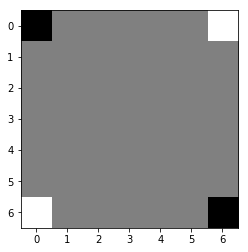

0.1


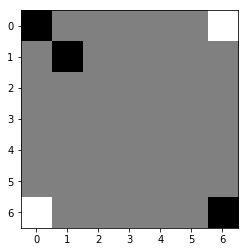

0.0


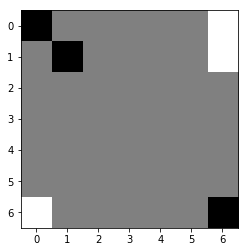

0.0


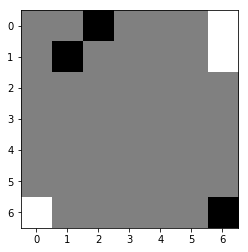

0.0


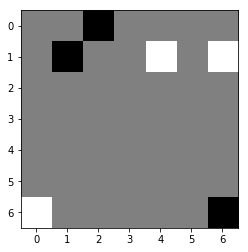

0.0


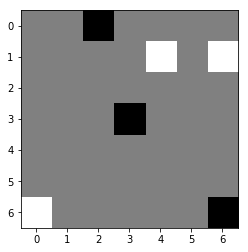

-0.2


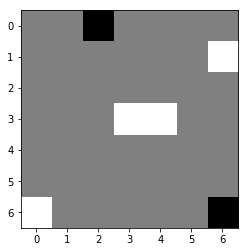

0.0


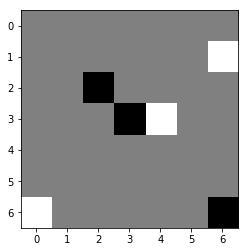

-0.2


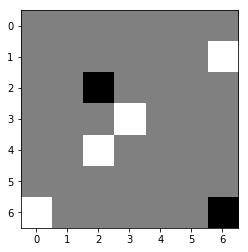

-0.2


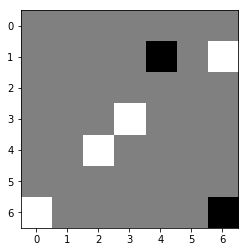

-0.4


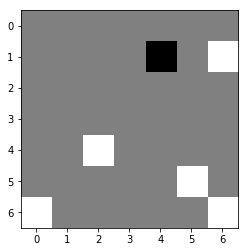

-0.30000000000000004


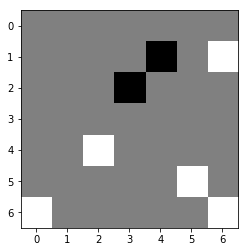

-0.30000000000000004


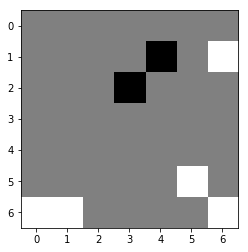

-0.2


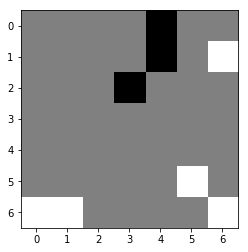

-0.2


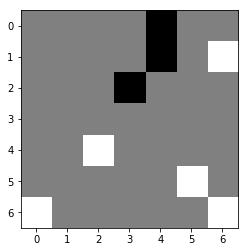

-0.2


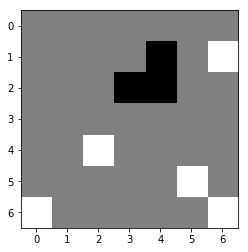

-0.5


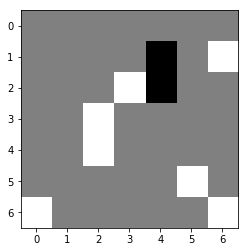

-0.2


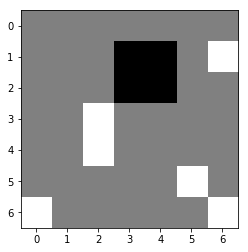

-0.2


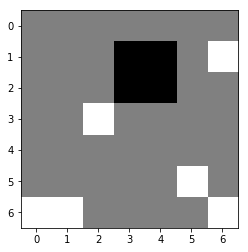

0.0


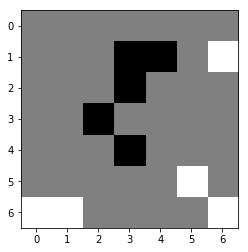

-0.4


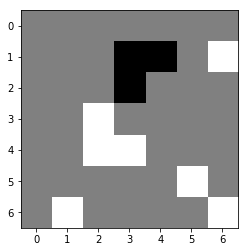

-0.30000000000000004


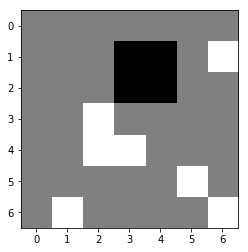

-0.30000000000000004


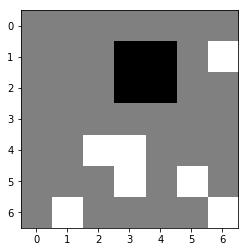

0.2


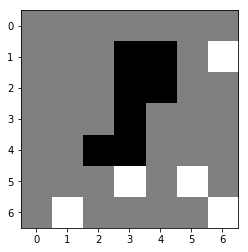

0.1


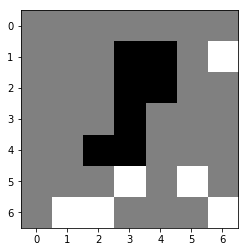

0.2


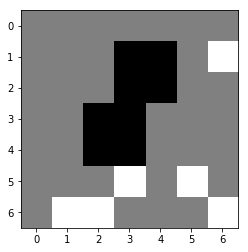

0.2


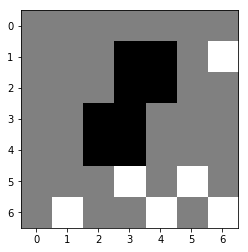

0.30000000000000004


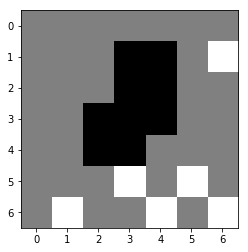

0.1


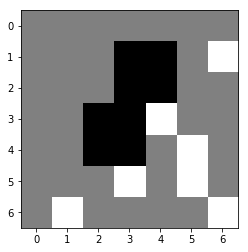

0.5


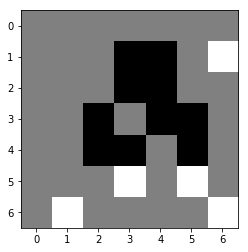

0.0


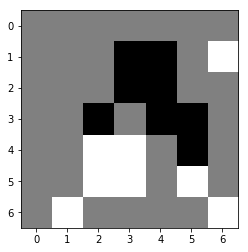

0.5


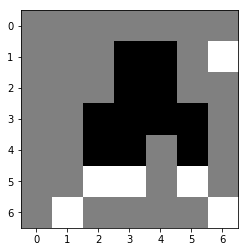

0.0


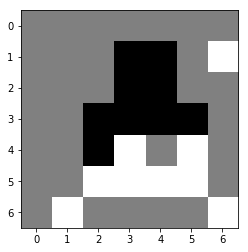

1.0


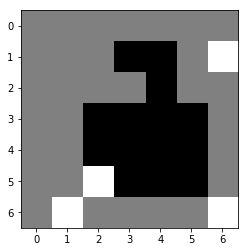

0.7000000000000001


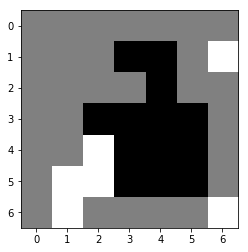

0.9


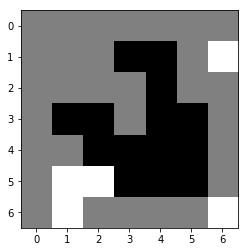

-0.30000000000000004


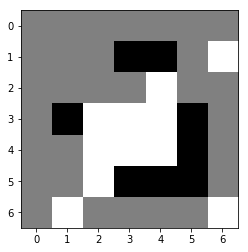

-0.30000000000000004


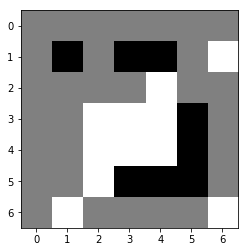

-0.8


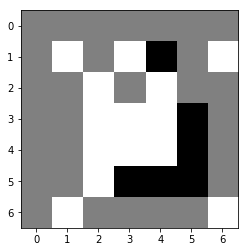

0.4


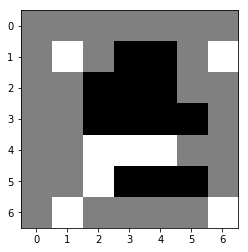

-0.2


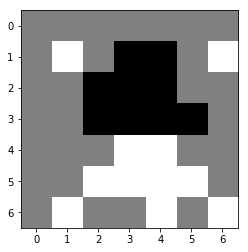

0.4


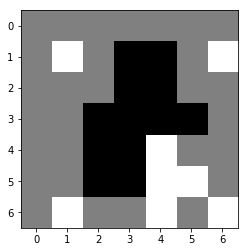

0.1


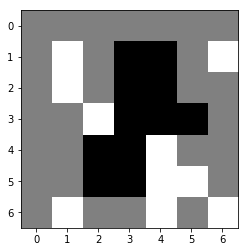

0.5


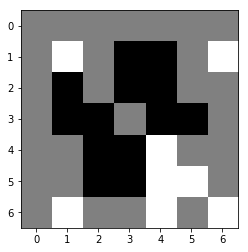

0.1


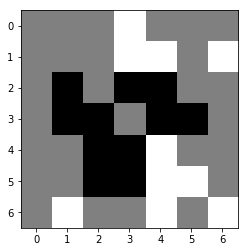

0.30000000000000004


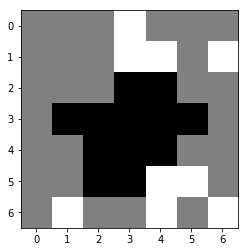

0.30000000000000004


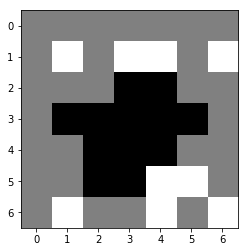

0.7000000000000001


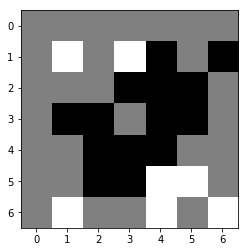

0.6000000000000001


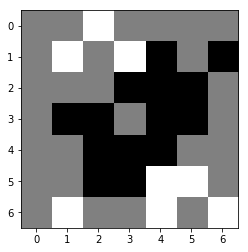

0.6000000000000001


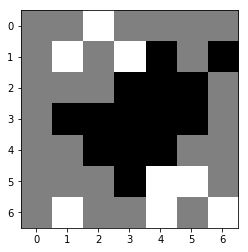

0.2


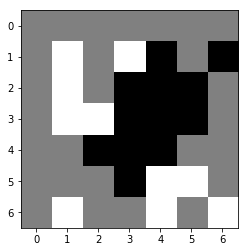

1.2000000000000002


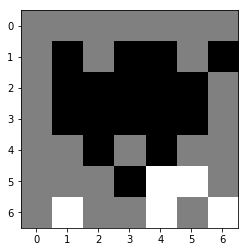

0.8


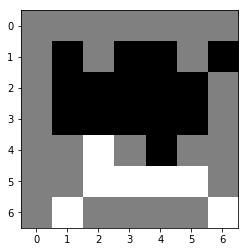

1.2000000000000002


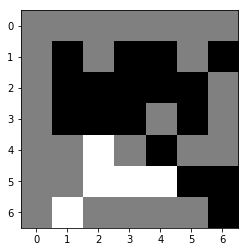

0.5


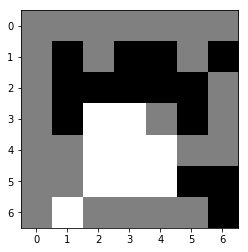

0.5


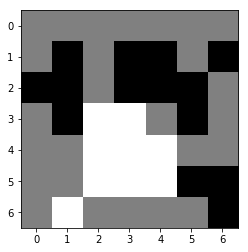

-0.30000000000000004


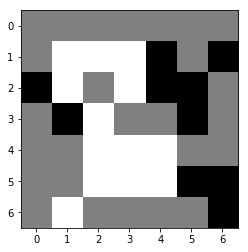

0.30000000000000004


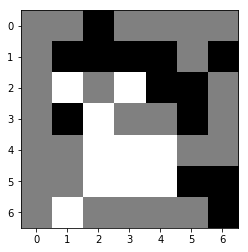

0.0


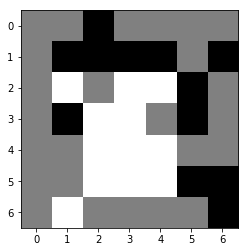

0.30000000000000004


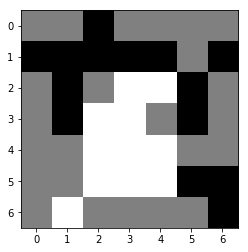

-0.7000000000000001


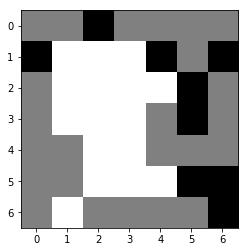

-0.7000000000000001


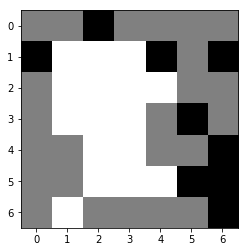

-1.2000000000000002


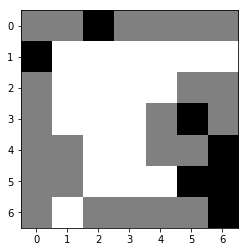

-0.30000000000000004


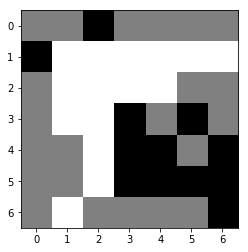

-0.6000000000000001


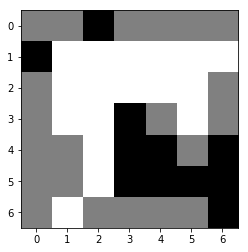

0.2


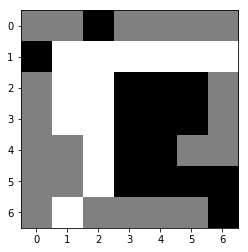

0.2


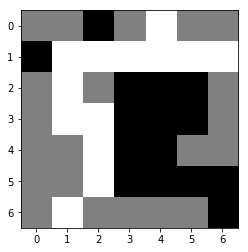

1.4000000000000001


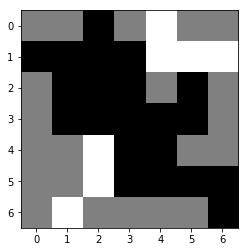

0.2


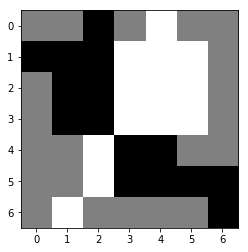

0.6000000000000001


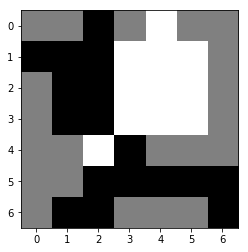

0.0


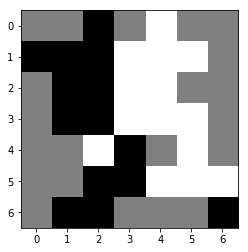

0.2


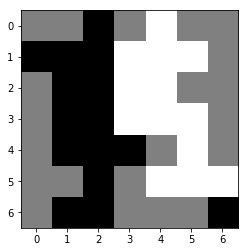

-0.6000000000000001


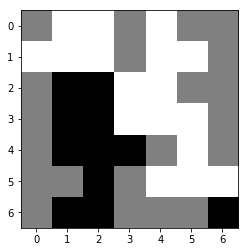

0.7000000000000001


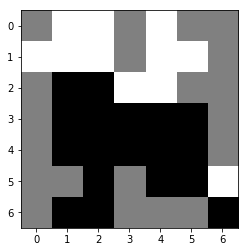

0.7000000000000001


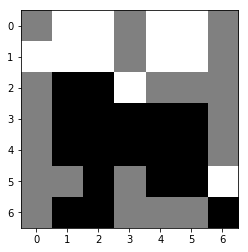

0.7000000000000001


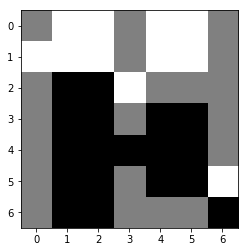

0.5


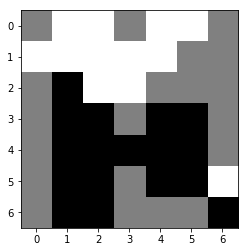

0.5


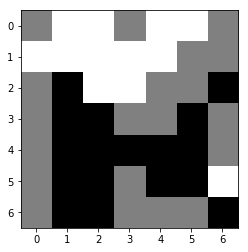

-0.1


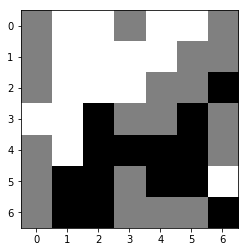

0.30000000000000004


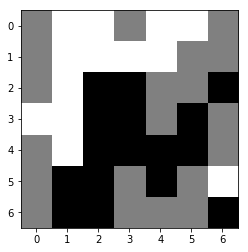

-0.9


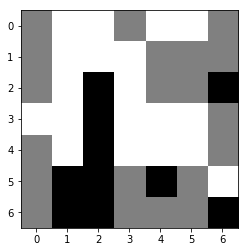

-0.30000000000000004


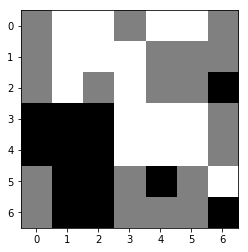

-0.6000000000000001


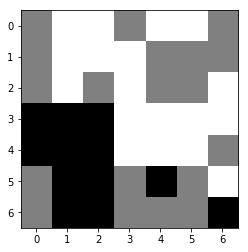

0.6000000000000001


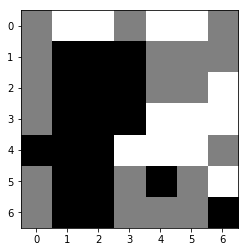

0.2


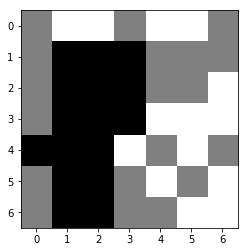

0.8


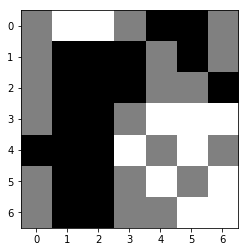

-0.2


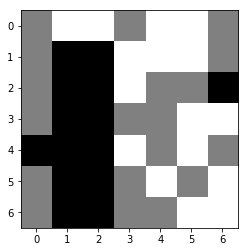

0.30000000000000004


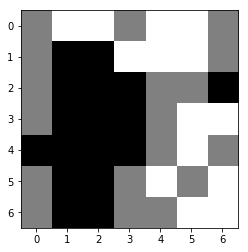

-0.1


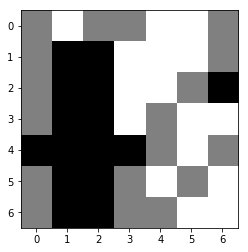

0.7000000000000001


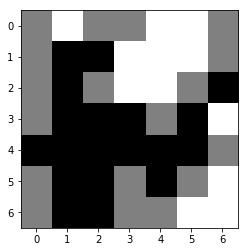

0.30000000000000004


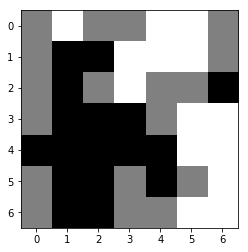

1.4000000000000001


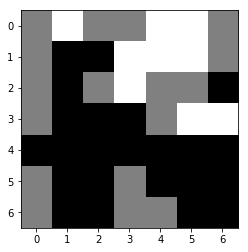

1.1


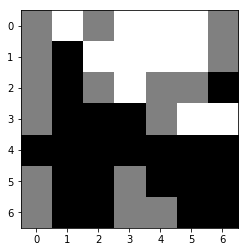

1.7000000000000002


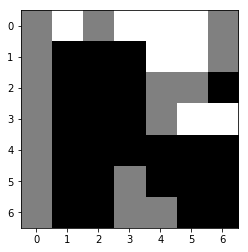

0.7000000000000001


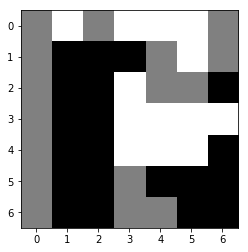

1.7000000000000002


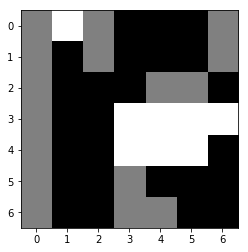

0.5


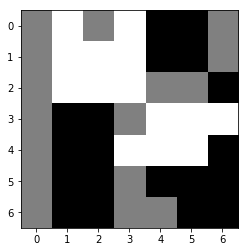

0.5


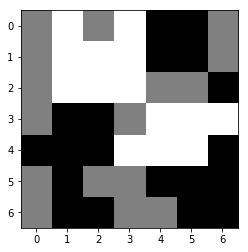

0.0


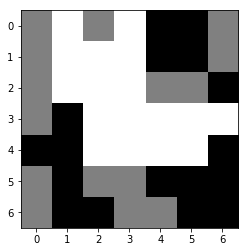

1.1


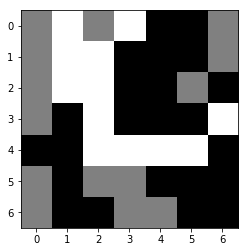

-0.1


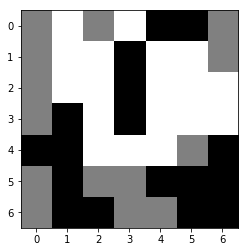

0.7000000000000001


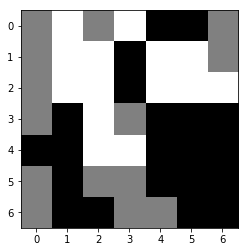

0.0


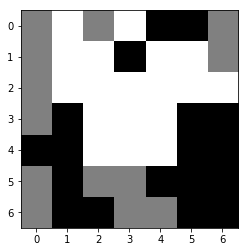

0.6000000000000001


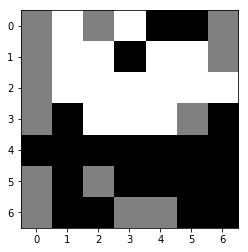

-0.2


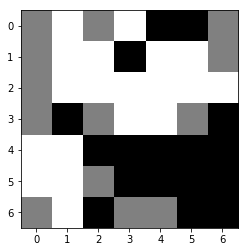

0.0


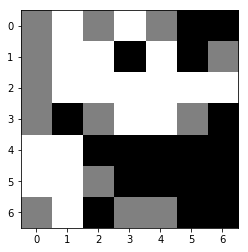

-0.7000000000000001


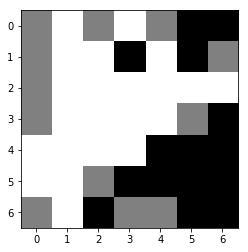

0.2


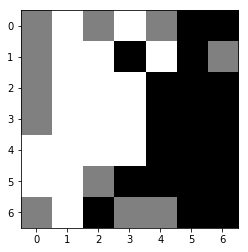

-0.2


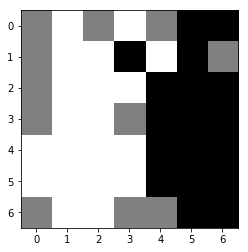

0.8


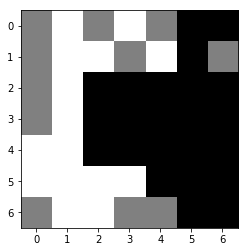

0.2


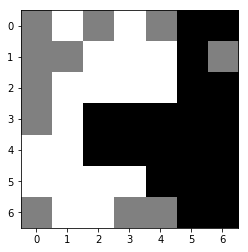

1.0


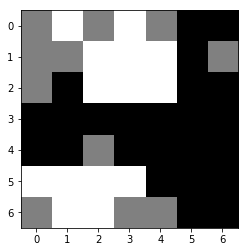

0.0


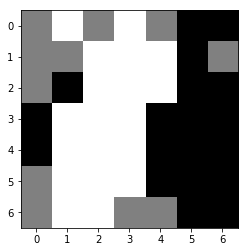

0.6000000000000001


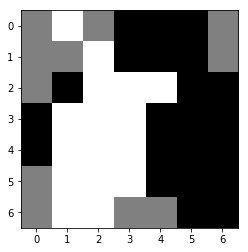

0.1


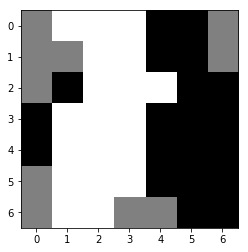

1.0


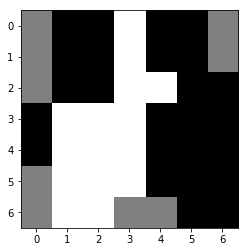

0.7000000000000001


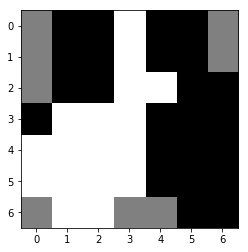

0.7000000000000001


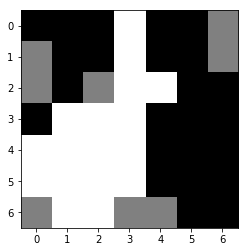

0.0


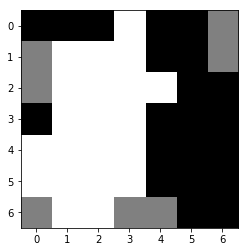

0.5


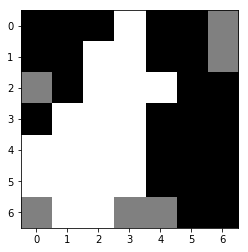

-0.30000000000000004


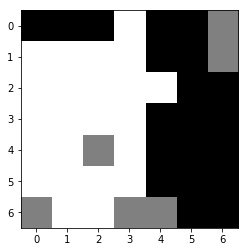

1.3


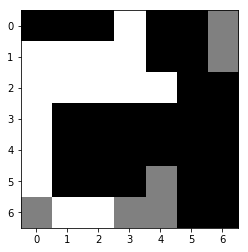

0.9


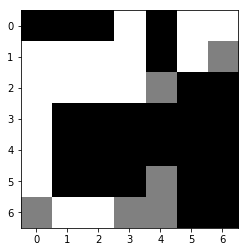

0.9


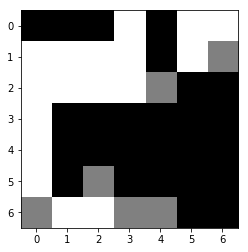

-0.1


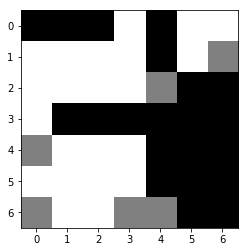

In [ ]:
game = Ataxx()
turn = -1
print("-1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    with tf.device("/cpu:0"):
        pos0, pos1, _ = actor.get_stochastic_action(game.get_feature_map(turn), game.get_mask(turn), \
                                              is_target=True)
    game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

1 is actor
0.0


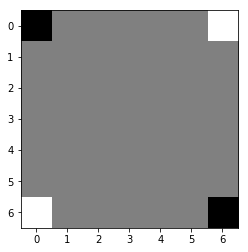

0.1


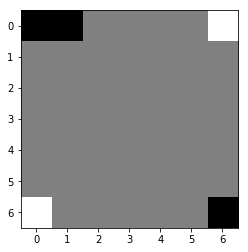

predicted prob for this move is: 0.239719
0.1


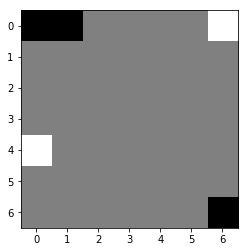

0.2


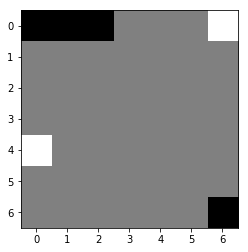

predicted prob for this move is: 0.410743
0.2


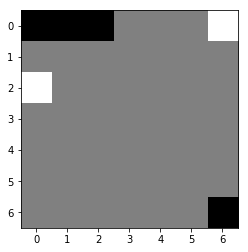

0.5


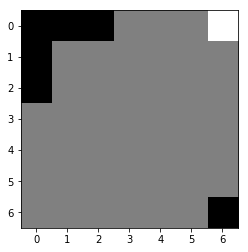

predicted prob for this move is: 0.166497
0.5


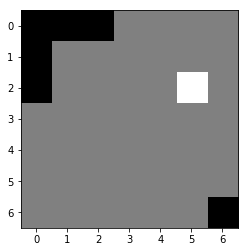

100


In [9]:
game = Ataxx()
turn = -1
print("1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == -1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

-1 is actor
0.0


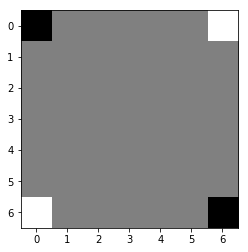

predicted prob for this move is: 0.0500829
0.1


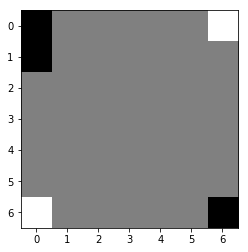

0.0


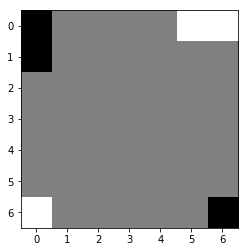

predicted prob for this move is: 0.0497656
0.1


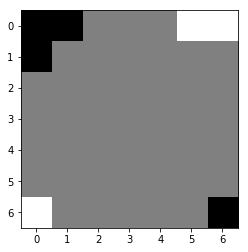

0.0


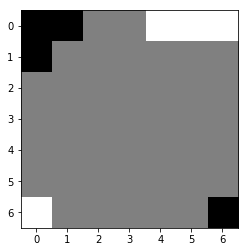

predicted prob for this move is: 0.0490917
0.0


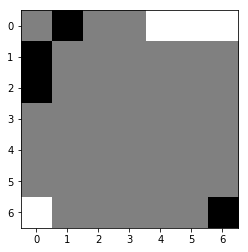

-0.2


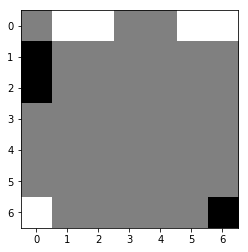

predicted prob for this move is: 0.0481683
-0.2


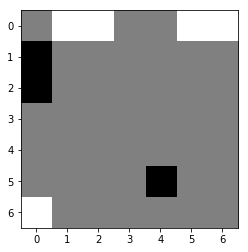

-0.7000000000000001


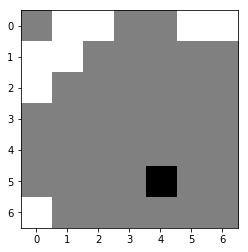

predicted prob for this move is: 0.0457362
-0.6000000000000001


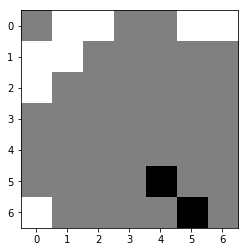

-0.7000000000000001


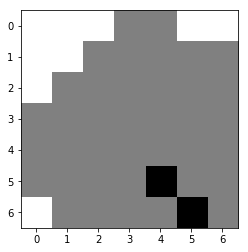

predicted prob for this move is: 0.0453432
-0.7000000000000001


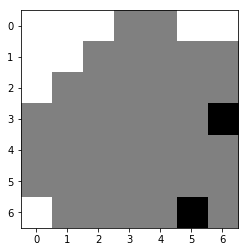

-0.9


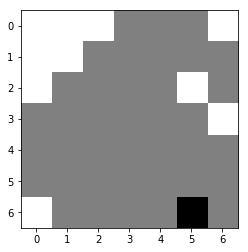

predicted prob for this move is: 0.0476256
-0.8


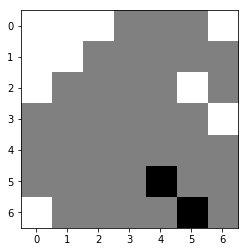

-100


In [29]:
game = Ataxx()
turn = -1
print("-1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == 1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

In [50]:
graph = 0

def reinforcement_data_generator(actor_model, actor_target, critic_model, critic_target, relay, \
                                 train_critic=True, step_per_episode=50, \
                                 BATCH_SIZE=64, GAMMA=0.99, RELAY_SIZE=10000): 
    global graph
    with graph.as_default():
        max_score = 1
        min_score = 0.02
        policy_mask_init = 0.01

        actor = ActorNetwork(target_model=actor_target, model=actor_model)
        critic = CriticNetwork(target_model=critic_target, model=actor_model)
        print("actor critic prepared")

        while True:
            reward = 0
            step = 0

            game = Ataxx()
            turn = -1 # start turn is -1

            while abs(game.evaluate(turn, turn, max_score, min_score)) != max_score:
                new_sample = [] # prepare to collect new sample

                pos0, pos1, cur_action_mask = actor.get_noised_action(game, turn, epsilon=0.1, mask_init=policy_mask_init, verbose=0) # get proposed action

                new_state = game.simu_move_to(turn, pos0, pos1)

                # create new_sample and add that to relay
                new_sample.append(game.get_feature_map(turn)) # cur_state
                new_sample.append(game.get_mask(turn)) # cur_mask
                new_sample.append(actor.get_action_prob(game, turn)) # cur_action
                new_sample.append(cur_action_mask) # cur_action_mask

                game.move_to(turn, pos0, pos1) # do the move here if the move is valid
                turn = -turn # the turn now is the next turn, what we are learning for is -turn

                new_sample.append(game.evaluate(-turn, turn, max_score, min_score)) # cur_reward
                if abs(new_sample[-1]) == max_score:
                    new_sample.append(None) 
                else:
                    new_sample.append(game.get_feature_map(turn)) # new_state

                relay.add_sample(new_sample)

            if relay.size() > BATCH_SIZE:
                for t in range(step_per_episode):
                    cur_state, cur_mask, cur_action, cur_action_mask, \
                        cur_reward, new_state = relay.get_batch(BATCH_SIZE)
                    q_target = np.zeros(BATCH_SIZE)

                    for k in range(BATCH_SIZE):
                        if new_state[k] is None:
                            q_target[k] = cur_reward[k]
                        else:
                            # generate new action
                            board = new_state[k][0] - new_state[k][1]
                            tmp_game = Ataxx(board) # recover the game board

                            new_action, new_action_mask = actor.get_noised_action(tmp_game, 1, epsilon=0, return_position=False, 
                                                                        mask_init=policy_mask_init, is_target=True, verbose=False)
                            q_new = critic.target_model.predict([new_state[k].reshape(1, 2, 7, 7), 
                                                                new_action.reshape(1, 2, 7, 7),
                                                                new_action_mask.reshape(1, 2, 7, 7)])[0]
                            q_target[k] = cur_reward[k] - GAMMA*q_new # cuz this q_new is for the opponent
                    if train_critic:
                        yield [cur_state, cur_action, cur_action_mask], q_target
                    else:
                        yield [cur_state, cur_mask, cur_action_mask], np.zeros(BATCH_SIZE)

def actor_critic_trainer(epochs=1000, check_point=True, steps_per_epoch=50, \
                           BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=10000, TAU=0.001, LRA=0.0001, LRC=0.0001): 
    actor = ActorNetwork(TAU, LRA, 0)
    critic = CriticNetwork(TAU, LRC)
    relay = Relay(RELAY_SIZE)
    global graph
    graph = tf.get_default_graph()

    with tf.device('/cpu'):
        actor_critic_model = Model(inputs=[actor.model.inputs[0], actor.model.inputs[1], critic.frozen_model.inputs[2]],
                                   outputs=[critic.frozen_model([actor.model.inputs[0], actor.model.outputs[0], critic.frozen_model.inputs[2]])])
        sgd = SGD(lr=LRA, decay=5e-7, momentum=0.9, nesterov=True)
        actor_critic_model.compile(loss=neg_linear_loss, optimizer=sgd)
    gpu_ac_model = multi_gpu_model(actor_critic_model, gpus=4)
    gpu_ac_model.compile(loss=neg_linear_loss, optimizer=Adam(lr=LRA))
    print(gpu_ac_model.summary())
    
    for ep in range(epochs):
        critic.gpu_model.fit_generator(reinforcement_data_generator(actor.model, actor.target_model, \
                                                                    critic.model, critic.target_model, \
                                                                    relay, train_critic=True, \
                                                                    step_per_episode=50, \
                                                                    BATCH_SIZE=256, GAMMA=0.99, RELAY_SIZE=RELAY_SIZE),\
                                       verbose=1, steps_per_epoch=steps_per_epoch, \
                                       #workers=8, use_multiprocessing=True
                                      )
        gpu_ac_model.fit_generator(reinforcement_data_generator(actor.model, actor.target_model, \
                                                                critic.model, critic.target_model, \
                                                                relay, train_critic=False, \
                                                                step_per_episode=50, \
                                                                BATCH_SIZE=256, GAMMA=0.99, RELAY_SIZE=RELAY_SIZE),\
                                   verbose=1, steps_per_epoch=steps_per_epoch, \
                                   #workers=8, use_multiprocessing=True
                                  )
        actor.target_train()
        critic.target_train()
        
        if check_point:
            actor.save()
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(actor.get_action_prob(tmp_game, -1, is_target=True))

In [51]:
actor_critic_trainer(epochs=1000, check_point=True, steps_per_epoch=50, \
                     BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=10000, \
                     TAU=0.001, LRA=0.0001, LRC=0.0001) 
    

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:121: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 64, 5, 5)     1216        input_153[0][0]                  
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 64, 5, 5)     256         conv2d_242[0][0]                 
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 64, 5, 5)     36928       batch_normalization_271[0][0]    
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_161 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
input_162 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
multiply_64 (Multiply)          (None, 2, 7, 7)      0           input_161[0][0]                  
                                                                 input_162[0][0]                  
__________________________________________________________________________________________________
input_160 (InputLayer)          (None, 2, 7, 7)      0                                            
__________

50/50 [==============================] - 127s 3s/step - loss: 1.9434 - mean_squared_error: 1.9434


Exception ignored in: <generator object reinforcement_data_generator at 0x7f765f58e468>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 117s 2s/step - loss: -1.4782e-08


Exception ignored in: <generator object reinforcement_data_generator at 0x7f765f58e468>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.02041597]]

 [[ 0.02040417  0.02040417  0.02040417  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02042603  0.02042381  0.02041361  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02040417  0.02042197  0.02040417  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02040417  0.02040417  0.0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 108s 2s/step - loss: -3.7905e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.0204167 ]]

 [[ 0.02040579  0.02040579  0.0204107   0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.020414    0.02040579  0.02042309  0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.02040579  0.02040579  0.02040579  0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.02040579  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 107s 2s/step - loss: 1.4529e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02041829]]

 [[ 0.02040545  0.02040545  0.02043251  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0.02040545  0.02042651  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0.02040545  0.02040961  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 106s 2s/step - loss: -7.9488e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02041747]]

 [[ 0.02040438  0.02040438  0.02045121  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0.02040438  0.02042737  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0.02040438  0.02041601  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 106s 2s/step - loss: 1.4668e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02041208]]

 [[ 0.02040343  0.02040343  0.0204699   0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0.02040343  0.02042824  0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0.02040343  0.02042096  0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: -6.9197e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041005  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]]

 [[ 0.02040233  0.02040233  0.02048798  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0.02040233  0.02042876  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0.02040233  0.02042454  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: -9.8068e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041354  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]]

 [[ 0.02040141  0.02040141  0.02050594  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0.02040141  0.02043002  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0.02040141  0.02042576  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 104s 2s/step - loss: -3.1758e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041675  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]]

 [[ 0.02040056  0.02040056  0.02052318  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0.02040056  0.02043022  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0.02040056  0.02042694  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: 1.5972e-08


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041998  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]]

 [[ 0.02039975  0.02039975  0.02053815  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0.02039975  0.02043092  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0.02039975  0.02042914  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 104s 2s/step - loss: -2.9756e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204231   0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]]

 [[ 0.02039894  0.02040579  0.0205518   0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0.02039894  0.02043077  0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0.02039894  0.02042754  0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 103s 2s/step - loss: -3.9209e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02042691  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]]

 [[ 0.02039819  0.02041248  0.02056349  0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0.02039819  0.0204301   0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0.02039819  0.02042566  0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 3.9442e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204308   0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]]

 [[ 0.02039758  0.02041801  0.02057318  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0.02039758  0.02042926  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0.02039758  0.02042391  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: -1.4156e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043401  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]]

 [[ 0.02039705  0.02042411  0.02058309  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0.02039705  0.02042831  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0.02039705  0.02042199  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 103s 2s/step - loss: 6.5193e-10


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043587  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]]

 [[ 0.02039659  0.02043026  0.020593    0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0.02039659  0.02042667  0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0.02039659  0.02042037  0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 5.0245e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204375   0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]]

 [[ 0.02039614  0.02043639  0.02060285  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0.02039614  0.02042501  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0.02039614  0.02041861  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 102s 2s/step - loss: 2.3004e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043931  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]]

 [[ 0.02039566  0.02044197  0.02061351  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0.02039566  0.02042458  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0.02039566  0.02041656  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 101s 2s/step - loss: -1.8813e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044123  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]]

 [[ 0.02039513  0.0204482   0.0206238   0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0.02039513  0.02042557  0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0.02039513  0.0204139   0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: -3.5949e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204425   0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]]

 [[ 0.02039455  0.02045457  0.02063477  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0.02039455  0.02042698  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0.02039455  0.02041113  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 7.1246e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044372  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]]

 [[ 0.02039393  0.02046089  0.02064561  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039731  0.02039393  0.02042882  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039393  0.02039393  0.02040839  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039393  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 101s 2s/step - loss: 4.0047e-10


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044491  0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]]

 [[ 0.02039324  0.02046709  0.02065576  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02040218  0.02039324  0.02043024  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02039324  0.02039324  0.02040604  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02039324  0.020393

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
49/50 [============================>.] - ETA: 1s - loss: -3.6208e-09

KeyboardInterrupt: 